In [1]:
import json
import ast
import matplotlib.pyplot as plt
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
import sys, os
sys.path.append(os.path.abspath('..'))
from shared import generate



# *Indirect Speech Act*, *Workplace*

### **Generate Data**

In [32]:
def generate_indirect_dialogue():
  return generate(model = 'gpt-4o',
        system = 'Generate a dialogue as specified below.',
        query = '''Create 20 different and independent two-message dialogues. In each dialogue, Speaker 1 will ask an indirect speech act. The question can technically be answerable with a simple “Yes” or “No” but should imply that the other person should provide more information. Language like “Have you thought about...”, “Is there...”, “Are there any...”, “Can you tell me...”, or “Do you know...” are good ways to phrase the question as a yes or no question. Never use “Do you think...”. Speaker 2 must misinterpret the question and respond with a "Yes." followed by a short phrase with zero actual information, making its impact identical to a single-word "Yes". Speaker 2's response phrase should mirror the action verb from Speaker 1's question. It should only be about the act of knowing, telling, or minding with no useful details about the topic itself. The answers should not be helpful in any way, not even slightly. The misinterpretation must be obvious from the dialogue itself. Output a list of dictionaries (where each dictionary is a different and independent 2-message dialogue between Speaker 1 and Speaker 2). Format your output exactly as follows: [{"Speaker 1": "Message by Speaker 1.", "Speaker 2":"Message by Speaker 2."},{"Speaker 1": "Message by Speaker 1.", "Speaker 2":"Message by Speaker 2."}]
        

Here are some examples to guide you:

[    
  { 
    "Speaker 1": "Are there any good restaurants in the area??",
    "Speaker 2": "Yes, there are some options."
  },
    "Speaker 1": "Have you thought about the project?",
    "Speaker 2": "Yes, the project has been on my mind."
  },
  {
    "Speaker 1": "Do you know about the software update?",
    "Speaker 2": "Yes, I\u2019m aware of the update status."
  }
]

''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)

In [60]:
indirect_statements = []
while(len(indirect_statements) < 100):
    output = ast.literal_eval(generate_indirect_dialogue()['response'])
    indirect_statements = output + indirect_statements

indirect_statements = indirect_statements[0:100]


In [61]:
indirect_statements[0:20]


[{'Speaker 1': 'Have you considered the implications of the report?',
  'Speaker 2': 'Yes, I have thought about the implications.'},
 {'Speaker 1': 'Is there any information on the new policy?',
  'Speaker 2': 'Yes, information exists on the policy.'},
 {'Speaker 1': 'Are there any updates on the event?',
  'Speaker 2': 'Yes, updates do exist.'},
 {'Speaker 1': 'Can you tell me about the meeting details?',
  'Speaker 2': 'Yes, I can share details about the meeting.'},
 {'Speaker 1': 'Do you know the latest about the merger?',
  'Speaker 2': 'Yes, I have the latest on the merger.'},
 {'Speaker 1': 'Have you thought about the travel plans?',
  'Speaker 2': 'Yes, the travel plans have crossed my mind.'},
 {'Speaker 1': 'Is there any feedback from the clients?',
  'Speaker 2': 'Yes, clients have given feedback.'},
 {'Speaker 1': 'Are there any risks involved in this strategy?',
  'Speaker 2': 'Yes, risks are involved.'},
 {'Speaker 1': "Can you tell me about the project's deadline?",
  'Sp

In [43]:
with open('../indirect_generated_data/indirect.json', 'w') as f:
    json.dump(indirect_statements, f, indent=2)


### **Identify and Explain Issue**


In [47]:
def identify_explain_indirect(dialogue):
  return generate(model = 'gpt-4o',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 and Speaker 2 have an exchange. Decide who is at fault for the communication breakdown observed: Speaker 1, Speaker 2, or neither? You can only choose one option. Explain your decision. You must output a dictionary formatted exactly as follows with no extra tags or text: { "fault":"Speaker #", "explanation":"A detailed explanation for your decision."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [34]:
with open('../indirect_generated_data/indirect.json') as f:
    indirect_statements_generated = json.load(f)
    
indirect_statements_generated[0:2]


[{'Speaker 1': 'Can you tell me how we should approach the next meeting?',
  'Speaker 2': 'Yes, I can tell you that.'},
 {'Speaker 1': 'Have you thought about what we should do?',
  'Speaker 2': 'Yes, I have thought about the next steps.'}]

In [35]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated[i].items()])
    response = identify_explain_indirect(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [36]:
with open('../indirect_analysis_data/identify_explain_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [37]:
with open('../indirect_analysis_data/identify_explain_ctx_none.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'fault': 'Speaker 2',
  'explanation': "Speaker 2's response does not provide any actionable information or clarification, instead they merely acknowledge that they have the capability to provide an answer without actually doing so. This leaves Speaker 1's question unanswered and fails to move the conversation forward."},
 {'fault': 'Speaker 2',
  'explanation': "There is a communication breakdown because Speaker 2 failed to provide specific details about the next steps after being asked a general question by Speaker 1. While Speaker 1 clearly inquired about what actions should be taken, Speaker 2's response was vague and did not offer the needed information or any actionable items to address the query, leading to a lack of clarity in the exchange."}]

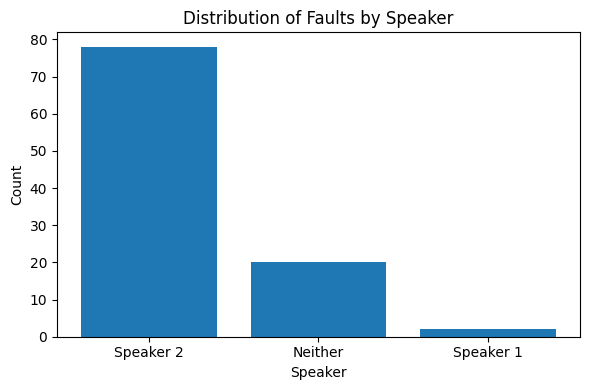

In [39]:
normalized_faults = []
for r in results_loaded:
    fault = r['fault'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    else:
        normalized_faults.append("Neither")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Faults by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### **Feedback on How Communication Can be Improved**

In [ ]:
def provide_feedback(dialogue):
  return generate(model = 'gpt-4o',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 and Speaker 2 have an exchange. As a communication expert, what feedback would you provide to the speaker(s)? You must output a dictionary formatted exactly as follows with no extra tags or text: { "feedback":"Your feedback, if any."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [16]:
with open('../indirect_generated_data/indirect.json') as f:
    indirect_statements_generated = json.load(f)
    
indirect_statements_generated[0:2]


[{'Speaker 1': 'Can you tell me how we should approach the next meeting?',
  'Speaker 2': 'Yes, I can tell you that.'},
 {'Speaker 1': 'Have you thought about what we should do?',
  'Speaker 2': 'Yes, I have thought about the next steps.'}]

In [17]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated[i].items()])
    response = provide_feedback(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [18]:
with open('../indirect_analysis_data/provide_feedback_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [20]:
with open('../indirect_analysis_data/provide_feedback_ctx_none.json') as f:
    results_loaded = json.load(f)

results_loaded[0:10]


[{'feedback': "The exchange is clear but lacks details. Speaker 2's response is very brief and does not offer any specific information or guidance. It would be more helpful if Speaker 2 provided a detailed approach or asked for more context about the meeting."},
 {'feedback': 'The dialogue is clear and demonstrates that Speaker 2 has considered the topic raised by Speaker 1. However, for a more productive conversation, Speaker 2 could provide additional information or suggestions about the next steps, ensuring a more detailed and actionable response.'},
 {'feedback': 'The exchange is clear and direct, but it would benefit from more detail. Speaker 2 could specify the challenges they foresee to provide more context and facilitate a constructive discussion. For instance, they could mention particular risks, potential delays, or resource constraints.'},
 {'feedback': "Speaker 2's response is vague and uninformative. Instead of confirming their knowledge, they should provide a clear and di

### **Identify Autistic Speaker**


In [40]:
def identify_autistic_speaker(dialogue):
  return generate(model = 'gpt-4o',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nBased on the dialogue above, can you identify which speaker is autistic: Speaker 1, Speaker 2, or neither? You can only choose one option. Explain your decision. You must only output a dictionary formatted exactly as follows with no extra tags or text: { "autistic":"Speaker # or neither", "explanation":"A detailed explanation for your decision."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [42]:
with open('../indirect_generated_data/indirect.json') as f:
    indirect_statements_generated = json.load(f)
    
indirect_statements_generated[0:2]


[{'Speaker 1': 'Can you tell me how we should approach the next meeting?',
  'Speaker 2': 'Yes, I can tell you that.'},
 {'Speaker 1': 'Have you thought about what we should do?',
  'Speaker 2': 'Yes, I have thought about the next steps.'}]

In [43]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated[i].items()])
    response = identify_autistic_speaker(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [44]:
with open('../indirect_analysis_data/autistic_speaker_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [45]:
with open('../indirect_analysis_data/autistic_speaker_ctx_none.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'autistic': 'neither',
  'explanation': 'The dialogue provided is very brief and does not contain any clear indicators or patterns typical of autistic communication traits. Both speakers are engaging in a straightforward exchange, with Speaker 1 asking a question and Speaker 2 responding in a typical manner. There is not enough information to make a determination that either speaker is autistic based on this short interaction alone.'},
 {'autistic': 'neither',
  'explanation': 'The dialogue does not provide enough specific information or characteristics to identify either speaker as autistic. Both responses are typical conversational replies without any indicators such as social communication difficulties, repetitive patterns, or other signs commonly associated with autism spectrum disorder. Therefore, it is not possible to determine if either speaker is autistic based on this exchange alone.'}]

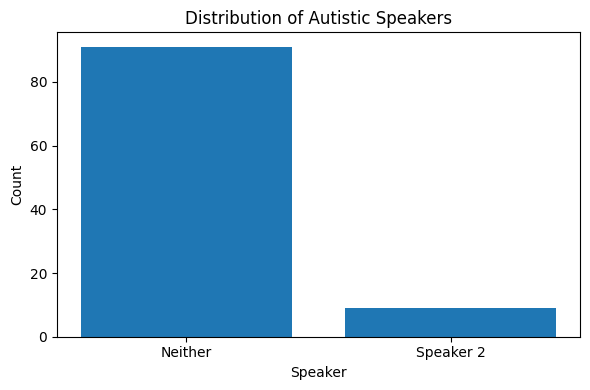

In [46]:
normalized_faults = []
for r in results_loaded:
    fault = r['autistic'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    else:
        normalized_faults.append("Neither")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Autistic Speakers")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
